# Chaîne de traitement _data science_.
## _Data wrangling_ avec `python` ([`scipy`](https://www.scipy.org/), [`scikit-learn`](https://scikit-learn.org/)) 


|Auteur|Centre|Modification|
|---|---|---|
|P. Halftermeyer|Orléans|2018/11/17|

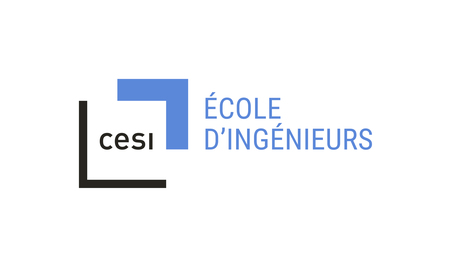

Nous allons essayer, dans le cadre de ce workshop, de prendre en main un jeu de données réel depuis l'import automatisé des fichers jusqu'à la préparation en vue d'alimenter un algorithme de _ML_.

Le _dataset_ présente des données immobilières californiennes. Il compte des variables telles que la population, le salaire médian, le prix moyen d'un logement, _etc_. Et ce pour chaque _block group_ (le _block group_ est la la plus petite division administrative aux Etats-Unis - entre 500 et 5000 personnes).

### Objectifs

On cherche à mettre au point un modèle de prédiction du prix médian d'un logement en fonction des autres informations. C'est clairement un problème [_supervisé_](https://fr.wikipedia.org/wiki/Apprentissage_supervis%C3%A9) de [_régression multivarié_](https://fr.wikipedia.org/wiki/R%C3%A9gression_lin%C3%A9aire_multiple).

### Mesure de performance

Elle n'interviendra que lors de la partie _Machine Learning_ de ce _workshop_, celà dit, il convient d'avoir une idée des objectifs dès le début de projet. 

On s'intéressera à terme à la minimisation de la [_root mean square error (RMSE)_](https://en.wikipedia.org/wiki/Root-mean-square_deviation) et/ou de à la [_mean absolute error (MAE)_](https://en.wikipedia.org/wiki/Mean_absolute_error) de notre modèle :

$$
\newcommand\x{\mathbf{x}}
\newcommand\X{\mathbf{X}}
\newcommand\y{\mathbf{y}}
\newcommand\Y{\mathbf{Y}}
\newcommand\RMSE{\mbox{RMSE}}
\newcommand\MAE{\mbox{MAE}}
$$
$$
\RMSE(\X,h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(\x^{(i)})-y^{(i)})^2}}
$$

$$
\MAE(\X,h)=\frac{\sum_{i=1}^{m}{\lvert h(\x^{(i)})-y^{(i)})\rvert}}{m}
$$

$h$ étant la fonction de prédiction du modèle.


### Préparation de l'environnement

Ci-dessous quelques imports et précautions préalables à notre travail. Il n'est pas inutile de les parcourir.

In [1]:
# compatibilité python 2 et python 3
from __future__ import division, print_function, unicode_literals

# imports
import numpy as np
import os

# stabilité du notebook d'une exécution à l'autre
np.random.seed(42)

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "workflowDS"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID) # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# ignorer les warnings inutiles (voir SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Import des données

Il convient d'automatiser l'import des données. On va implémenter une fonction qui se charge de :
* télécharger l'archive
* extraire les fichiers

On peut imaginer qu'une variante de cette fonction pourrait être incluse dans un module `python` annexe afin de faire partie de la boîte à outils du _data scientist_ que vous êtes. On la gardera dans le _notebook_ pour l'exercice.

In [6]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://github.com/ph10r/eiSpeInfoDS/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    urllib.request.urlretrieve(HOUSING_URL, HOUSING_PATH + "/housing.tgz")
    file = tarfile.open(HOUSING_PATH + "/housing.tgz")
    file.extractall(HOUSING_PATH)
    file.close()

On peut maintenant importer les données :

In [7]:
fetch_housing_data()

### Chargement des données en mémoire

De même, on va créer une fonction utilisant [`pandas`](https://pandas.pydata.org/) qui charge les données en mémoire dans un [`Pandas DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame).

In [8]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path, encoding='utf-8')

In [9]:
housing = load_housing_data()

### Coup d'oeil

1. Observons les premières lignes de notre `DataFrame` avec la méthode [`head()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html?highlight=head):

In [13]:
print(housing.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


2. Utilisons maintenant [`info()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html?highlight=info#pandas.DataFrame.info) pour obtenir une description du jeu de données :

In [14]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


3. La fonction [`value_counts()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html?highlight=value_counts) permet de connaître, par exemple, le nombre de valeurs différentes d'une [`Series`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html#pandas.Series) telle que `ocean_proximity`, qui semble être catégorielle:

In [16]:
print(housing.ocean_proximity.value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


4. La méthode `describe()` permet enfin d'obtenir un résumé statistique des valeurs numériques :

In [17]:
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

5. On peut utiliser la fonction [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html?highlight=hist#matplotlib.pyplot.hist) [`matplotlib`](https://matplotlib.org/) pour afficher un histogramme par attribut numérique.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f617834e610>,
      dtype=object)

<Figure size 864x864 with 0 Axes>

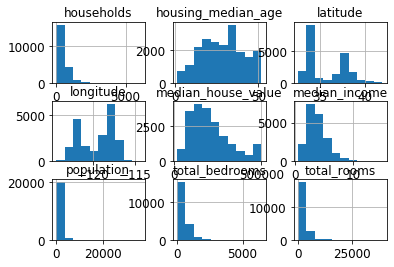

In [21]:
plt.figure(figsize=[12.0,12.0])
plt.rc
housing.hist()

#### Remarques :
* `median_income` n'est pas en dollars US (On apprend en consultant les auteurs du _dataset_ que les valeurs ont été mises à l'échelles et _capées_ entre 0.49999 et 15.0001).
* `housing_median_age` et `median_house_value` sont capées également. C'est un problème en ce qui concerne la deuxième de ces _features_ car c'est notre variable-cible. Notre modèle devra apprendre à respecter ce _caping_ et le client devra être informé : cette limite convient-elle à son besoin ? Si tel n'est pas le cas, on pourra essayer de collecter d'autres données ou retirer les valeurs concernées du _dataset_.
* Les échelles sont très différentes d'une _feature_ à l'autre. Un _scaling_ sera sans doute nécessaire pour obtenir un modèle performant.
* plusieurs histogrammes sont _tail heavy_ alors que les algorithmes de _ML_ fonctionnent en général mieux avec les _courbes en cloche_.

### Création d'un jeu de test

#### Jeu de test aléatoire
Nous avons déjà trop observé ce jeu de donné : il est grand temps d'en réserver un échantillon de test. En effet, votre cerveau, remarquable machine à apprendre, commence déjà à établir des _patrons_. Celà pourrait biaiser la démarche menant au choix du modèle et aboutir à du _surapprentissage_. On ne doit utiliser le jeu de test que lorsqu'on est proche du but et assez convaincu que le modèle qu'on a établi est le bon. Dans le cas contraire, on fait du _data snooping_. Note pour plus tard :

> Pas de _data snooping_ !

Créer un jeu de test est simple : on met aléatoirement 20% des données de côtés.

In [22]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [23]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


C'est une solution imparfaite car le comportement de `np.random` est imprévisible. Même en ayant fixé la _graine aléatoire_ à 42 (comme il est d'usage), on n'est toujours pas assurés que deux exécutions aboutiront au même résultat.

#### Utilisation d'une fonction de hachage

Ci-dessous, on définit une fonction `split_train_test_by_id` construisant un jeu de test en hachant un identifiant unique à chaque ligne (ex : le numéro de la ligne). Le résultat de ce _hash_ est mappé sur l'ensemble booléen $\{0,1\}$ en respectant le ratio afin de décider la destination de l'enregistrement (test ou entraînement).

In [24]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#### Utilisation de `scikit-learn`

La bibliothèque de _machine learning_ [`scikit-learn`](https://scikit-learn.org/) propose une fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) réalisant ce traîtement. Son utilisation est fortement conseillée maintenant que nous avons compris son fonctionnement.

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
[train, test] = train_test_split(housing)

In [27]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Il faut s'assurer de ne pas introduire de biais statistique, d'une part, et de respecter le [_stratified sampling_](https://en.wikipedia.org/wiki/Stratified_sampling), de l'autre. Par exemple, dans le cas de notre exemple, on va tâcher d'avoir une distribution représentative du `median_income`. Pour éviter les biais de sous-représentation ou sur-représentation, on essaye d'avoir un nombre limité de strates (strates que l'on préfèrera donc assez larges).

#### Echantillonage stratifié

Après discussion avec des experts métiers, nous sommes convaincus que le revenu moyen est une variable-clef. Nous désirons effectuer un échantillonage où les jeux d'entraînement et de test respectent les proportions de représentation des différentes catégories de salaire. Pour celà, nous commençons par créer une variable `income_cat`, pendant catégoriel de la variable numérique `median_income`

In [28]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false

On peut observer les effectifs de chaque catégories.

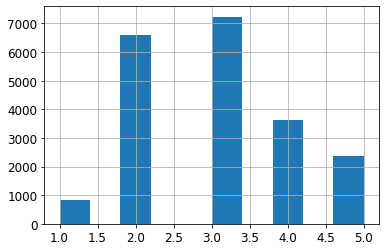

In [29]:
housing["income_cat"].hist()

On peut maintenant utiliser [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) pour échantillonner le jeu de données en respectant notre contrainte :

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    print(train_index, test_index) # 1 seul tour de boucle si n_splits = 1
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

[17606 18632 14650 ... 13908 11159 15775] [ 5241 10970 20351 ...  4019 12107  2398]


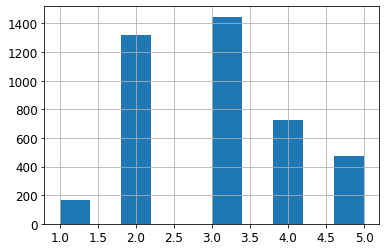

In [31]:
strat_test_set["income_cat"].hist()

Notre échantillonnage respecte bien les proportions du jeu initial. On n'a plus besoin de la colonne `income_cat` : on la supprime avec [`drop()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

In [35]:
for set_ in (strat_train_set, strat_test_set):
    housing.drop(columns ='income_cat')

In [36]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3.0
...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND,4.0
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND,2.0
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND,3.0
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN,3.0


> *Remarque* : si le jeu de données était plus volumineux, on pourrait être amené à devoir créer un jeu d'exploration. Ce n'est pas la peine ici.

### Explorer le jeu de données

Notre jeu de test étant constitué, nous pouvons commencer l'exploration. Nous allons travailler sur une copie du jeu d'entraînement pour éviter toute mauvaise surprise.

In [37]:
housing = strat_train_set.copy()

#### Visualisation de données géographiques

La bibliothèque [`matplotlib`]() permet de représenter des données sous formes graphique. On peut s'y initier _via_ ce [tutoriel](https://www.python-course.eu/matplotlib.php).

Les coordonnées géographiques de nos enregistrements étant connues, on a envie de les représenter sur le plan :

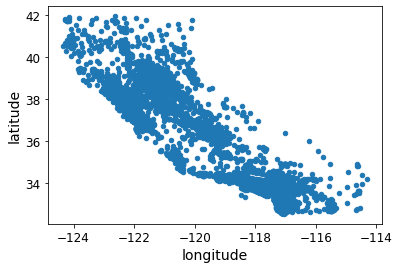

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Ce n'est pas très lisible, on aimerait jouer sur la transparence des points pour mettre en évidence les densité de point :

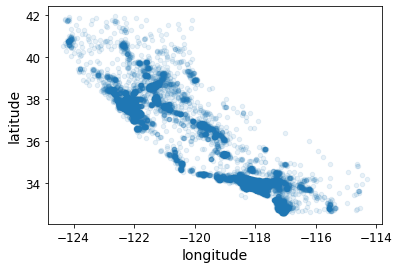

In [40]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha= 0.1)

On peut faire varier à loisir la taille de nos marqueurs (option `s`) et leur couleur (option `c` : on utilise une palette `cmap` prédéfinie nommée `jet`). Ici on veut distinguer les zones en fonction de leur population et de leur revenu moyen. 

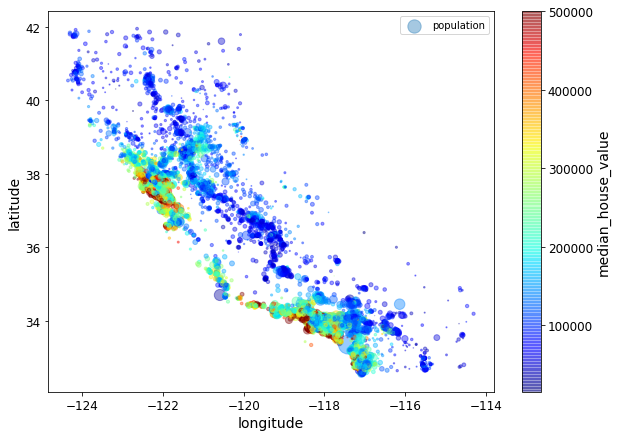

In [43]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
#save_fig("housing_prices_scatterplot") # Produira une erreur si le répertoire n'existe pas

On constate que la situation géographique importe. On peut imaginer que la valeur moyenne d'une maison est corrélée à la proximité à l'océan, d'une part, et qu'un algorithme de _clustering_, d'autre part, donnerait des résultat intéressants.

Si nous souhaitions visualiser d'autres données géographique. Nous pourrions utiliser [une autre palette](https://matplotlib.org/examples/color/colormaps_reference.html) en fonction de ce que nous voudrions démontrer. Dans l'exemple précédent, les couleurs sont sur un axe chaud/froid ; une palette prise au hasard telle que `cubehelix` aurait eu un rendu moins facile à interpréter.  La couleur n'est pas à négliger lorsqu'il s'agit de mettre une idée en évidence.

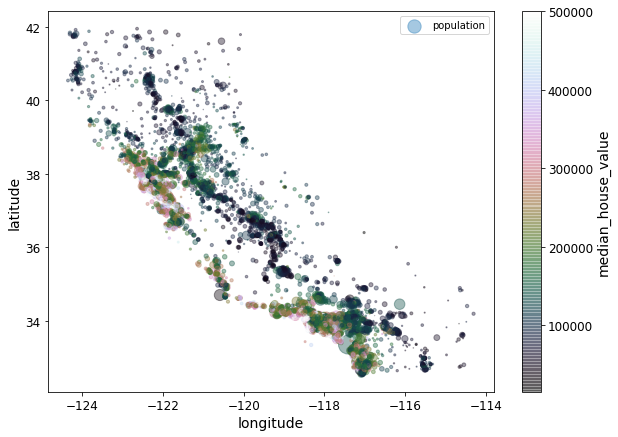

In [44]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("cubehelix"), colorbar=True,
    sharex=False)
plt.legend()

#### Recherche de corrélation

Les variables d'un jeu de données peuvent être liées deux à deux (plus ou moins fortement, positivement ou négativement), c'est pourquoi on calcule leur [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)).

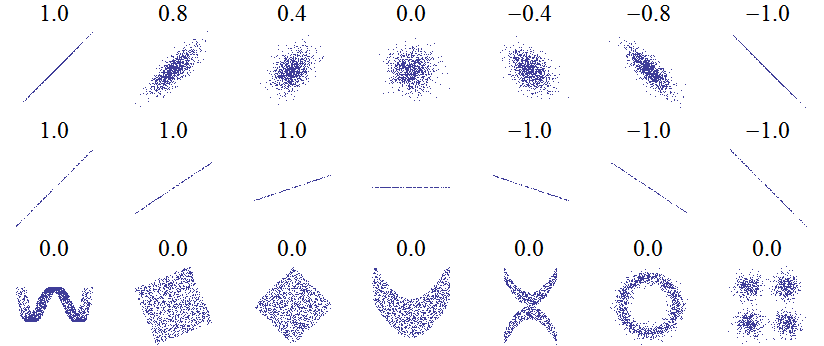

In [45]:
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/0/02/Correlation_examples.png")

Pour un jeu de données de petite taille tel que le notre, on peut calculer la matrice de corrélation avec [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) et en afficher une série, par exemple celle correspondant à la variable `median_income` :

In [47]:
data = housing.corr()
print(data["median_income"])

longitude            -0.019583
latitude             -0.075205
housing_median_age   -0.111360
total_rooms           0.200087
total_bedrooms       -0.009740
population            0.002380
households            0.010781
median_income         1.000000
median_house_value    0.687160
income_cat            0.902156
Name: median_income, dtype: float64


[`scatter_matrix`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html) permet de visualiser les relations entre variables ainsi qu'un histogramme en _bonus_ pour chaque variable sur la diagonale :

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61701760d0>,
      dtype=object)

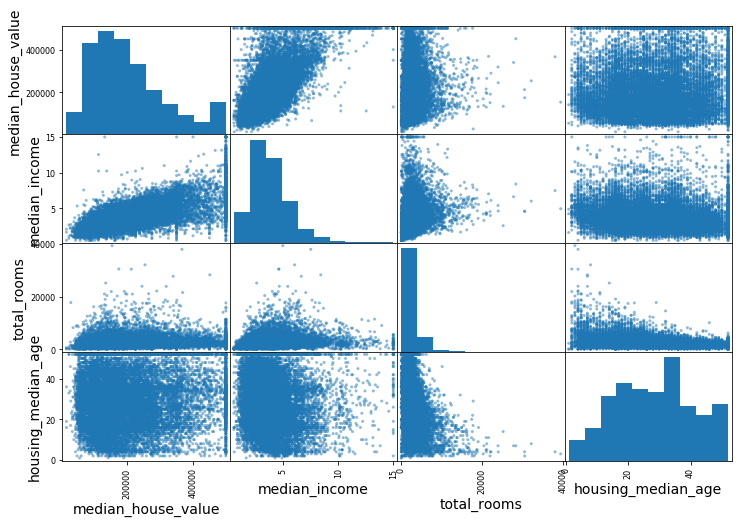

In [49]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
#save_fig("scatter_matrix_plot")

On remarque d'ores et déjà une corrélation positive forte entre `median_income` et `median_house_value`. C'est prometteur.

Zoomons sur ce candidat :

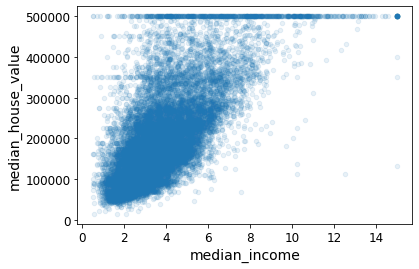

In [51]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

#save_fig("income_vs_house_value_scatterplot")

On voit quelques pistes d'amélioration :
- Les lignes horizontales du dernier graphique pourraient correspondre aux cases d'un questionnaire. Il serait légitime de supprimer les valeurs correspondantes si l'on voulait obtenir un résultat optimal.
- Certaines distributions sont _tail-heavy_, on pourrait tenter de les transformer, pourquoi pas en utilisant un _logarithme_.
- On a aussi envie de combiner certains attributs. En effet, par exemple, il semble logique de rapprocher le nombre de pièces dans le district(`total_rooms`) du nombre total de logements dans ce district (`households`).


#### Combinaison d'attributs

Comme suggéré précédemment, on va créer de nouvelles variables `rooms_per_household`, `bedrooms_per_room` et `population_per_household` et visualiser leur corrélation à `median_house_value`.

In [53]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_rom"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [54]:
data = housing.corr()
data["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
income_cat                  0.642274
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_rom           -0.259984
Name: median_house_value, dtype: float64

Pas mal ! On obtient une corrélation négative assez prononcée avec `bedrooms_per_room`.
On va maintenant préparer les données pour l'apprentissage automatique.

## Préparation des données pour les algorithmes de ML

Il est indispensable de scripter cette préparation pour plusieurs raisons :
* Afin de la rendre reproductible, par exemple si on obtient une version plus récente du jeu initial.
* Afin de se constituer une bibliothèque d'utilitaires.
* Afin que ces transformation puissent être utilisées _à chaud_ en production sans intervention humaine.
* Afin d'effectuer des bancs d'essai entre plusieurs stratégies de péparation.

On va commencer par scinder le jeu de données. D'une part, les variables-cibles, ou étiquettes, souvent notées $\Y$ (une seule ici donc $\y$) et de l'autre les autres variables notées $\X$. On obtiendra `housing_labels` et `housing`.

In [55]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Nettoyage des données

##### Valeurs manquantes dans `total_bedrooms`

On a pu remarquer plus haut, en appelant la méthode `info()`, que la _feature_ `total_bedrooms` comptait des valeurs manquantes.

In [56]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
income_cat            16512 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


On a plusieurs options en cas de valeur manquante:
1. Supprimer l'instance
1. Supprimer la _feature_
1. Remplacer par une valeur (0, médiane, _etc_.)

On pourrait utiliser [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna), [`drop()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html#pandas.DataFrame.drop), [`fillna()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)

In [57]:
# option 1 :
housing.dropna(subset=["total_bedrooms"])
# option 2 :
# housing.drop("total_bedrooms", axis=1)
# option 3 :
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,3.0
...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND,4.0
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND,2.0
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND,3.0
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN,3.0


On teste ces options sur l'échantillon concerné `sample_incomplete_rows`.

In [58]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2.0
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4.0
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4.0
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2.0
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3.0


In [59]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"]) # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [60]:
sample_incomplete_rows.drop("total_bedrooms", axis=1) # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN,2.0
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN,4.0
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN,4.0
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND,2.0
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN,3.0


In [61]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN,2.0
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN,4.0
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN,4.0
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND,2.0
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN,3.0


Pour plus de commodité, `scikit-learn` propose une classe dédiée à ce genre de traitements : [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).

In [62]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Attention : cette stratégie ne s'applique qu'aux variables numériques donc on doit _dropper_ les autres pour le traitement.

In [63]:
#housing_num = housing.drop('ocean_proximity', axis=1)
# Plus général :
housing_num = housing.select_dtypes(include=[np.number]) 

On peut maintenant _entraîner_ l'`Imputer` avec la méthode `fit()`.

In [64]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

> l'_API_ de `scikit_learn` est telle que les objets, qu'il soient des _estimateurs_, des _transformeurs_ ou des prédicteurs possèdent une syntaxe commune intuitive. Pour approfondir, la lecture de _API design for machine learning software: experiences from the scikit-learn project_ [Buitinck _et al._] est envisageable.

L'`Imputer` a calculé la médiane pour chaque variable et l'a stockée dans son attribut `statistics_`.

In [65]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [66]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

On peut alors transformer les données avec la méthode `transform()` de l'`Imputer` :

In [68]:
X = imputer.transform(housing_num)

Le résultat est un [`array`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.array.html) [`Numpy`](http://www.numpy.org/). On va en refaire un `DataFrame` en récupérant les noms de colonnes dans `housing_num`.

In [69]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

##### Attributs textuels et catégories

On s'intéresse maintenant aux variables catégorielles.

##### Numérisation

In [70]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Les algorithmes de _ML_ étant plus à l'aise avec des nombre, on _mappe_ ces catégories sur des nombres avec `OrdinalEncoder`. On utilise la méthode `fit_transform` qui enchaîne `fit` et `transform` comme son nom l'indique.

In [71]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

L'`encoder` donne accès au mapping des catégories :

In [72]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

> Attention ! Des algorithmes de ML peuvent considérer que des valeurs numériques telles que $1$ et $2$ plus proches l'une de l'autre que ne le sont $1$ et $4$. Ce n'est _a priori_ pas vrai ici si on mappe les catégories trivialement sur `[0,1,2,3,4]`. Le _1-hot encoding_ palie ce problème. Chaque catégorie va donner naissance à une nouvelle variable booléenne.

##### _One-hot encoding_

In [73]:
from sklearn.preprocessing import OneHotEncoder

On utilise la méthode `fit_transform` du [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) qui retourne une `sparse matrix`, version compressée qu'on peut révéler avec la méthode `toarray()`.

In [74]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # array creux par défaut

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

Une alternative est d'utiliser l'option `sparse` de l'encodeur.

In [ ]:
#CODE A COMPLETER
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # array dense

On a accès aux catégories _via_ l'attribut `categories_` de notre encodeur.

In [ ]:
cat_encoder.categories_

##### Transformations _ad hoc_

Il sera parfois nécessaire d'implémenter nos propres transformations. Rester en cohérence avec l'_API_ de `sci-kit learn` nous permettra de constituer des _pipeline_ de traitement homogènes.

`scikit-learn` étant basé sur le _duck typing_, l'implémentation d'un transformer sera celle d'une classe comportant ces méthodes :
- `fit()` (retournant souvent `self`)
- `transform()`
- `fit_transform()` (obtenue gratuitement en ajoutant `TransformerMixin` aux classes de base)

L'ajout de la classe `BaseEstimator` aux classes de base permettra plus tard le tuning automatisé des _hyper-paramètres_. Elle a pour effet d'ajouter les méthodes `get_params` et `set_params` à condition d'avoir un nombre fixe de paramètres dans le constructeur (on évitera `*args` et `**kwargs`).

L'exemple ci-dessous nous sert à créer les variables combinées :

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# index pour chaque colonne
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            #CODE A COMPLETER
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

> Remarque : ici notre _transformer_ possède un unique hyper-paramètre `add_bedrooms_per_room`. Il sera facile de modifier notre chaîne de traitement pour savoir si, oui ou non, ce paramètre doit être ajouté. Les paramètres permettent de retarder, voire d'automatiser, les prises de décision de ce genre.

In [ ]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
housing_extra_attribs

On peut reconstruire un `DataFrame` avec en-têtes.

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

##### _Feature scaling_

Les algos de ML ne marchent pas bien quand les _features_ ont des échelles très différentes (ex. `number_of_rooms` entre 0 et 40000 alors que `median_income` entre 0 et 15). Les stratégies pour y remédier sont : _min-max scaling_ et _standardization_.
* min-max scaling : _mappe_ [min,max] sur[0,1] ([`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))
* standardization : _mappe_ la moyenne sur zero avec variance unitaire. ([`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

La deuxième option est moins sensible aux [_valeurs aberrantes_](https://fr.wikipedia.org/wiki/Donn%C3%A9e_aberrante).


> C'est bien en fonction des données du jeu d'entraînement (seulement) qu'on effectura les mises à l'échelle.

##### _Pipeline_ de transformation

Nous désirons pouvoir créer un _transformer_ qui serait la résultante de tous les autres (réalisés dans le bon ordre). Par exemple, pour les attributs numériques :

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Il serait encore mieux de n'avoir pas à extraire manuellement les valeurs numériques. On aimerait pouvoir alimenter le _pipeline_ directement avec le `DataFrame` initial. On va utiliser [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) pour créer l'embranchement.

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

In [ ]:
housing_prepared.shape

Nous en avons terminé avec l'étape de préparation des données. Il est maintenant grand temps de passer à l'apprentissage !